In [30]:
# Import necessary libraries
import torch.cuda as torch_cuda
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.utils import make_grid

## Verify GPU

In [31]:
print('===VERIFY GPU===')
print('CUDA IS AVAILABLE:', torch_cuda.is_available())
print('DEVICE COUNT:', torch_cuda.device_count())
print('DEVICE NAME:', torch_cuda.get_device_name(0))

# If CUDA is available, print GPU details
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0)} bytes")
    print(f"GPU Memory Cached: {torch.cuda.memory_reserved(0)} bytes")

# Select device: GPU if available, otherwise CPU
device = torch.device('cuda:0' if torch_cuda.is_available() else 'cpu')


===VERIFY GPU===
CUDA IS AVAILABLE: True
DEVICE COUNT: 1
DEVICE NAME: NVIDIA RTX A4000
Number of GPUs: 1
GPU Name: NVIDIA RTX A4000
GPU Memory Allocated: 28268032 bytes
GPU Memory Cached: 50331648 bytes


## Dataset

In [32]:
# Define hyperparameters
batch_size = 16

# Take a subset of the dataset - we are only interested in two classes for now
classes = [0,1] 

# Define transformations: Convert to tensor and normalize
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))  # Get the images in the range [-1,1]
])

mnist_trainset = datasets.MNIST(
    root='Dataset',
    train=True,
    download=True,
    transform=transformations
)

mnist_testset = datasets.MNIST(
    root='Dataset',
    train=False,
    download=True,
    transform=transformations
)

train_indices = [i for i, label in enumerate(mnist_trainset.targets) if label in classes]
test_indices = [i for i, label in enumerate(mnist_testset.targets) if label in classes]

# Take a subset of the dataset based on the indices we identified as belonging to the class
train_subset = Subset(mnist_trainset, train_indices)
test_subset = Subset(mnist_testset, test_indices)


In [33]:
trainloader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True
)

testloader = DataLoader(
    test_subset,
    batch_size=batch_size,
    shuffle=False
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


TRAIN SET LENGTH: 12665
TEST SET LENGTH: 2115


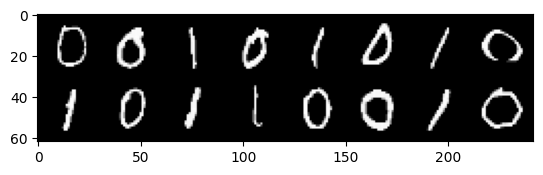

In [34]:
print('TRAIN SET LENGTH:', len(train_subset))
print('TEST SET LENGTH:', len(test_subset))

def imshow(img):

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), vmin=0, vmax=1)
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(make_grid(images))

## Model

In [35]:
momentum_coeff = 0.9
learning_rate = 0.01
learning_decay = 10**-9
epochs = 20

# Classes for MNIST digits
classes = (0,1)

In [36]:
# Define a multi-layer perceptron (MLP) model
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        # Flatten layer to convert 28x28 images into 784-dim vector
        self.flat = nn.Flatten()

        # Define linear layers
        self.input_layer = nn.Linear(784, 100)
        self.hidden_layer1 = nn.Linear(100, 100)
        self.hidden_layer2 = nn.Linear(100, 100)
        self.hidden_layer3 = nn.Linear(100, 100)
        self.hidden_layer4 = nn.Linear(100, 100)
        self.out = nn.Linear(100, 2)

        # Define dropout layers
        self.dropout_layer1 = nn.Dropout(p=0.5)
        self.dropout_layer2 = nn.Dropout(p=0.5)
        self.dropout_layer3 = nn.Dropout(p=0.5)
        self.dropout_layer4 = nn.Dropout(p=0.5)

    def forward(self, x, output=5):
        # Flatten the image into a 784-dim vector
        x = x.reshape(-1, 784)

        # Pass through layers with ReLU activation and dropout
        x = F.relu(self.input_layer(x))

        x = F.relu(self.hidden_layer1(x))
        if output == 1:
            return x
        x = self.dropout_layer1(x)
        
        x = F.relu(self.hidden_layer2(x))
        if output == 2:
            return x
        x = self.dropout_layer2(x)
        
        x = F.relu(self.hidden_layer3(x))
        if output == 3:
            return x
        x = self.dropout_layer3(x)
        
        x = F.relu(self.hidden_layer4(x))
        if output == 4:
            return x
        x = self.dropout_layer4(x)
        
        # IMPORTANT FIX: Do not apply softmax here.
        # CrossEntropyLoss expects raw logits.
        x = self.out(x)
        return x  # Return raw logits

# Instantiate and move model to the selected device
mlp = MLP().to(device)

loss_function = nn.CrossEntropyLoss()  # CrossEntropyLoss expects raw logits
optimizer = optim.SGD(mlp.parameters(), lr=learning_rate,
                      momentum=momentum_coeff, weight_decay=learning_decay)


def train(epoch):

    mlp.train()
    for batch_idx, (data, target) in enumerate(trainloader):

        data, target = data.to(device), target.to(device)


        optimizer.zero_grad()

        output = mlp(data, output=5)


        loss = loss_function(output, target)

        loss.backward()

        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {:>3}\t[{:>5}/{:>5} ({:>3.0f}%)]\tLoss: {:>7.6f}'.format(
                    epoch + 1, batch_idx * len(data), len(trainloader.dataset),
                    100. * batch_idx / len(trainloader), loss.item()))


def test():
    mlp.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in testloader:
            # Move data and targets to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = mlp(data, output=5)

            # Compute loss and accumulate
            test_loss += loss_function(output, target).item()

            # Get predicted classes
            pred = output.argmax(dim=1, keepdim=True)

            # Count how many predictions are correct
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Average loss over the entire test set
    test_loss /= len(testloader)

    # Print test performance
    print('\nTest set: Average loss: {:>10.4f}, Accuracy: {:>5}/{:>5} ({:>3.3f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))


# Run the training and testing for defined epochs
for epoch in range(epochs):
    train(epoch)
    test()


Train Epoch:   1	[    0/12665 (  0%)]	Loss: 0.701724
Train Epoch:   1	[ 1600/12665 ( 13%)]	Loss: 0.571560
Train Epoch:   1	[ 3200/12665 ( 25%)]	Loss: 0.000254
Train Epoch:   1	[ 4800/12665 ( 38%)]	Loss: 0.008750
Train Epoch:   1	[ 6400/12665 ( 51%)]	Loss: 0.000909
Train Epoch:   1	[ 8000/12665 ( 63%)]	Loss: 0.000707
Train Epoch:   1	[ 9600/12665 ( 76%)]	Loss: 0.024001
Train Epoch:   1	[11200/12665 ( 88%)]	Loss: 0.000430

Test set: Average loss:     0.0048, Accuracy:  2113/ 2115 (99.905%)

Train Epoch:   2	[    0/12665 (  0%)]	Loss: 0.006691
Train Epoch:   2	[ 1600/12665 ( 13%)]	Loss: 0.012598
Train Epoch:   2	[ 3200/12665 ( 25%)]	Loss: 0.000001
Train Epoch:   2	[ 4800/12665 ( 38%)]	Loss: 0.003370
Train Epoch:   2	[ 6400/12665 ( 51%)]	Loss: 0.000957
Train Epoch:   2	[ 8000/12665 ( 63%)]	Loss: 0.003492
Train Epoch:   2	[ 9600/12665 ( 76%)]	Loss: 0.004669
Train Epoch:   2	[11200/12665 ( 88%)]	Loss: 0.000074

Test set: Average loss:     0.0034, Accuracy:  2112/ 2115 (99.858%)

Train Epoch: